In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from matplotlib.animation import FuncAnimation

%matplotlib inline

from utils.pann_net import PANN, EulerCell_DAB
from utils.pann_utils import evaluate, create_vpvs, get_inputs
from utils.star_metric_adapter import (
    current_stress,
    locate,
    soft_switching,
    power,
    cu_loss,
)

# 日本語フォント
font_path = "/System/Library/Fonts/ヒラギノ角ゴシック W3.ttc"
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["axes.unicode_minus"] = False

# DAB コンバータの物理ベースニューラルネットワーク（PANN）による動作条件の転移学習

このノートブックでは、学習済みの PANN モデルを使用して、様々な動作条件への転移学習を実証します。

## 目次

1. **ドメイン外動作条件への転移**: 学習なしで新しい動作条件に適応
2. **より多くの自由度を持つ変調への転移**: Triple Phase Shift から Extended Phase Shift へ
3. **異なる回路パラメータへの転移**: ネットワークパラメータの直接割り当て
4. **様々な性能指標の評価**: 一つの PANN モデルで全ての性能指標を計算


## 1. ドメイン外動作条件への転移（学習不要！）

### ソースドメイン: Vin = 200 V, Vo = [160 V, 240 V]の範囲

### ターゲットドメインの例:

- 例 1: Vo = 120 V
- 例 2: Vo = 280 V
- 例 3: Vin = 300 V, Vo = 220 V
- 例 4: Vin = 300 V, Vo = 380 V


In [2]:
# 回路パラメータの初期推定とPANNの定義
n, RL, Lr = 1.0, 120e-3, 63e-6
Ts = 1 / 50e3
Tslen = 100
dt = Ts / Tslen

# DAB用のオイラーセルを定義
dab_Euler_cell = torch.jit.script(EulerCell_DAB(dt, Lr, RL, n))
# DAB用のPANNを定義
pann_dab = torch.jit.script(PANN(dab_Euler_cell))

# 学習済みモデルの読み込み（必要に応じて）
# pann_dab.load_state_dict(torch.load("model_pann.pth"))
# print(pann_dab.cell.n.item(), pann_dab.cell.RL.item(), pann_dab.cell.Lr.item())

In [3]:
##################################################
# 例1: Vo = 120 V
D0, D1, D2 = 0.08, 0.6, 0.92
Vin, Vref = 200, 120
Tsim = 100 * Ts  # シミュレーション時間（スイッチング周期の100倍を考慮）

# 変調パラメータのセットから電圧波形（vpとvs）を生成
vp, vs = create_vpvs(
    D0, D1, D2, Vin, Vref, Tslen, dt, Tsim, Ts, D1_cycle=0.5, D2_cycle=0.5
)
t = np.arange(0, len(vp) * dt, dt)

# numpy形式で入力テンソルを構築
inputs = np.hstack([vp[:, None], vs[:, None]])[None]
# torchのFloatTensorに変換
inputs = torch.FloatTensor(inputs)

##################################################
# 例2: Vo = 280 V
D0, D1, D2 = 0.2, 0.96, 0.68
Vin, Vref = 200, 280
Tsim = 100 * Ts

vp2, vs2 = create_vpvs(
    D0, D1, D2, Vin, Vref, Tslen, dt, Tsim, Ts, D1_cycle=0.5, D2_cycle=0.5
)
inputs2 = np.hstack([vp2[:, None], vs2[:, None]])[None]
inputs2 = torch.FloatTensor(inputs2)

##################################################
# 例3: Vin = 300 V, Vo = 220 V
D0, D1, D2 = 0.16, 0.78, 0.88
Vin, Vref = 300, 220
Tsim = 100 * Ts

vp3, vs3 = create_vpvs(
    D0, D1, D2, Vin, Vref, Tslen, dt, Tsim, Ts, D1_cycle=0.5, D2_cycle=0.5
)
inputs3 = np.hstack([vp3[:, None], vs3[:, None]])[None]
inputs3 = torch.FloatTensor(inputs3)

##################################################
# 例4: Vin = 300 V, Vo = 380 V
D0, D1, D2 = -0.08, 0.98, 0.8
Vin, Vref = 300, 380
Tsim = 100 * Ts

vp4, vs4 = create_vpvs(
    D0, D1, D2, Vin, Vref, Tslen, dt, Tsim, Ts, D1_cycle=0.5, D2_cycle=0.5
)
inputs4 = np.hstack([vp4[:, None], vs4[:, None]])[None]
inputs4 = torch.FloatTensor(inputs4)

In [4]:
# 各例に対してPANNを使用して状態変数iLを推論

##################################################
# 例1: Vo = 120 V
state_dim = 1
state0 = torch.zeros((inputs.shape[0], 1, state_dim))  # 初期値は0

pann_dab.eval()
with torch.no_grad():
    states = pann_dab(inputs, state0)

##################################################
# 例2: Vo = 280 V
state0 = torch.zeros((inputs2.shape[0], 1, state_dim))

pann_dab.eval()
with torch.no_grad():
    states2 = pann_dab(inputs2, state0)

##################################################
# 例3: Vin = 300 V, Vo = 220 V
state0 = torch.zeros((inputs3.shape[0], 1, state_dim))

pann_dab.eval()
with torch.no_grad():
    states3 = pann_dab(inputs3, state0)

##################################################
# 例4: Vin = 300 V, Vo = 380 V
state0 = torch.zeros((inputs4.shape[0], 1, state_dim))

pann_dab.eval()
with torch.no_grad():
    states4 = pann_dab(inputs4, state0)

/var/folders/f_/5hh5787972x33swmy27z8q0m0000gn/T/ipykernel_54643/3878493260.py:19: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  t, inputs, states = np.array(t), np.array(inputs), np.array(states)


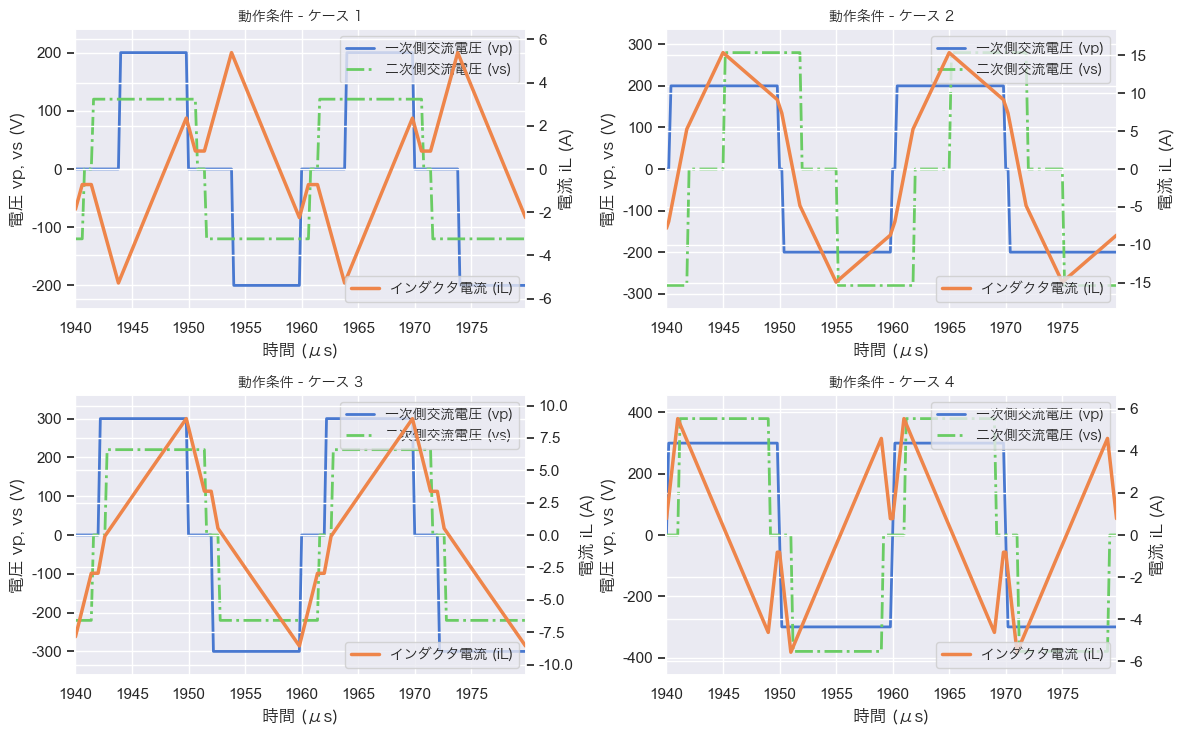

In [5]:
# 様々な動作条件の結果を可視化
%matplotlib inline

# 最後の2スイッチング周期分のデータを表示用に準備
if len(inputs.shape) == 3:
    t = t[-2 * Tslen :] * 1e6
    inputs = inputs[0, -2 * Tslen :]
    states = states[0, -2 * Tslen :]
    inputs2 = inputs2[0, -2 * Tslen :]
    states2 = states2[0, -2 * Tslen :]
    inputs3 = inputs3[0, -2 * Tslen :]
    states3 = states3[0, -2 * Tslen :]
    inputs4 = inputs4[0, -2 * Tslen :]
    states4 = states4[0, -2 * Tslen :]

# Seabornスタイルの設定
sns.set(style="darkgrid")

t, inputs, states = np.array(t), np.array(inputs), np.array(states)

# 図とサブプロットを作成
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(12, 7.5))

for i, (ax, _inputs, _states, case_num) in enumerate(
    zip(
        [ax11, ax12, ax21, ax22],
        [inputs, inputs2, inputs3, inputs4],
        [states, states2, states3, states4],
        [1, 2, 3, 4],
    )
):
    # 二軸プロット
    ax_2 = ax.twinx()

    # 電圧波形のプロット
    ax.plot(
        t,
        _inputs[:, 0],
        lw=2,
        label="一次側交流電圧 (vp)",
        color=sns.color_palette("muted")[0],
        linestyle="-",
    )
    ax.plot(
        t,
        _inputs[:, 1],
        lw=2,
        label="二次側交流電圧 (vs)",
        color=sns.color_palette("muted")[2],
        linestyle="-.",
    )

    # 電流波形のプロット
    ax_2.plot(
        t,
        _states[:, 0],
        lw=2.5,
        label="インダクタ電流 (iL)",
        color=sns.color_palette("muted")[1],
        linestyle="-",
    )

    # 軸の設定
    ax.set_xlim(t.min(), t.max())
    ax.set_ylim(-_inputs.max() * 1.2, _inputs.max() * 1.2)
    ax_2.set_ylim(-_states.max() * 1.2, _states.max() * 1.2)

    # ラベルとタイトル
    ax.set_title(
        f"動作条件 - ケース {case_num}",
        fontsize=16,
        weight="bold",
        fontproperties=font_prop,
    )
    ax.set_xlabel("時間 (μs)", fontsize=12, fontproperties=font_prop)
    ax.set_ylabel("電圧 vp, vs (V)", fontsize=12, fontproperties=font_prop)
    ax_2.set_ylabel("電流 iL (A)", fontsize=12, fontproperties=font_prop)

    # グリッドと凡例
    ax.grid(True)
    ax.legend(loc="upper right", fontsize=10, prop=font_prop)
    ax_2.legend(loc="lower right", fontsize=10, prop=font_prop)

# レイアウトの調整
plt.tight_layout()
plt.show()

## 2. より多くの自由度を持つ変調への転移（学習不要！）

### ソースドメイン: Triple Phase Shift 変調

### ターゲットドメイン: 5 自由度戦略（位相シフト角とデューティサイクルの両方が調整可能）

- 例 1: Vin = 200 V, Vo = 140 V, (D0, D1, D2) = (0.1, 0.92, 0.7), (φ1, φ2) = (50%, 35%)
- 例 2: Vin = 200 V, Vo = 260 V, (D0, D1, D2) = (0.1, 0.7, 0.92), (φ1, φ2) = (65%, 50%)


In [6]:
##################################################
# 例1: Vin = 200 V, Vo = 140 V, (D0, D1, D2) = (0.1, 0.92, 0.7), (φ1, φ2) = (50%, 35%)
D0, D1, D2 = 0.04, 0.84, 0.64
D1_cycle, D2_cycle = 0.5, 0.32
Vin, Vref = 200, 140
Tsim = 100 * Ts  # シミュレーション時間（スイッチング周期の100倍を考慮）

# 変調パラメータのセットから電圧波形（vpとvs）を生成
vp, vs = create_vpvs(
    D0,
    D1,
    D2,
    Vin,
    Vref,
    Tslen,
    dt,
    Tsim,
    Ts,
    D1_cycle=D1_cycle,
    D2_cycle=D2_cycle,
)
inputs = np.hstack([vp[:, None], vs[:, None]])[None]
# torchのFloatTensorに変換
inputs = torch.FloatTensor(inputs)

##################################################
# 例2: Vin = 200 V, Vo = 260 V, (D0, D1, D2) = (0.1, 0.7, 0.92), (φ1, φ2) = (65%, 50%)
D0, D1, D2 = 0.04, 0.64, 0.84
Vin, Vref = 200, 260
D1_cycle, D2_cycle = 0.68, 0.5
Tsim = 100 * Ts

# 変調パラメータのセットから電圧波形（vpとvs）を生成
vp2, vs2 = create_vpvs(
    D0, D1, D2, Vin, Vref, Tslen, dt, Tsim, Ts, D1_cycle=D1_cycle, D2_cycle=D2_cycle
)
inputs2 = np.hstack([vp2[:, None], vs2[:, None]])[None]
# torchのFloatTensorに変換
inputs2 = torch.FloatTensor(inputs2)

In [7]:
# 各例に対してPANNを使用して状態変数iLを推論

##################################################
# 例1: Vin = 200 V, Vo = 140 V, (D0, D1, D2) = (0.1, 0.92, 0.7), (φ1, φ2) = (50%, 35%)
state_dim = 1
state0 = torch.zeros((inputs.shape[0], 1, state_dim))  # 初期値は0

pann_dab.eval()
with torch.no_grad():
    states = pann_dab(inputs, state0)

##################################################
# 例2: Vin = 200 V, Vo = 260 V, (D0, D1, D2) = (0.1, 0.7, 0.92), (φ1, φ2) = (65%, 50%)
state0 = torch.zeros((inputs2.shape[0], 1, state_dim))

pann_dab.eval()
with torch.no_grad():
    states2 = pann_dab(inputs2, state0)

/var/folders/f_/5hh5787972x33swmy27z8q0m0000gn/T/ipykernel_54643/3243302729.py:15: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  t, inputs, states = np.array(t), np.array(inputs), np.array(states)


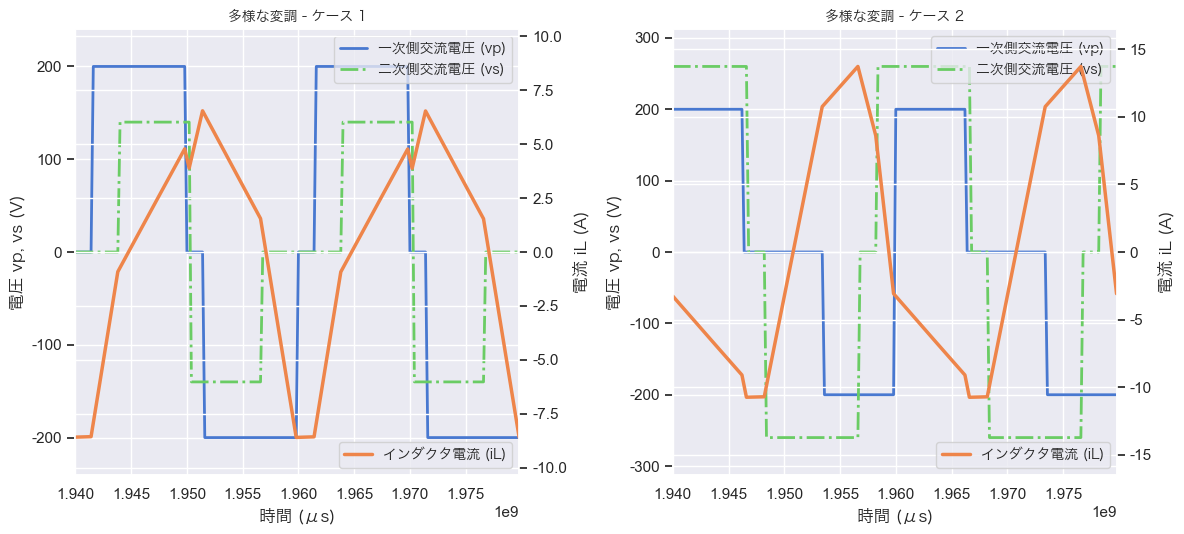

In [8]:
# 多様な変調戦略の結果を可視化
%matplotlib inline

# 最後の2スイッチング周期分のデータを表示用に準備
if len(inputs.shape) == 3:
    t = t[-2 * Tslen :] * 1e6
    inputs = inputs[0, -2 * Tslen :]
    states = states[0, -2 * Tslen :]
    inputs2 = inputs2[0, -2 * Tslen :]
    states2 = states2[0, -2 * Tslen :]

# Seabornスタイルの設定
sns.set(style="darkgrid")

t, inputs, states = np.array(t), np.array(inputs), np.array(states)

# 図とサブプロットを作成
fig, (ax11, ax12) = plt.subplots(1, 2, figsize=(12, 5.5))

for i, (ax, _inputs, _states, case_num) in enumerate(
    zip([ax11, ax12], [inputs, inputs2], [states, states2], [1, 2])
):
    # 二軸プロット
    ax_2 = ax.twinx()

    # 電圧波形のプロット
    ax.plot(
        t,
        _inputs[:, 0],
        lw=2,
        label="一次側交流電圧 (vp)",
        color=sns.color_palette("muted")[0],
        linestyle="-",
    )
    ax.plot(
        t,
        _inputs[:, 1],
        lw=2,
        label="二次側交流電圧 (vs)",
        color=sns.color_palette("muted")[2],
        linestyle="-.",
    )

    # 電流波形のプロット
    ax_2.plot(
        t,
        _states[:, 0],
        lw=2.5,
        label="インダクタ電流 (iL)",
        color=sns.color_palette("muted")[1],
        linestyle="-",
    )

    # 軸の設定
    ax.set_xlim(t.min(), t.max())
    ax.set_ylim(-_inputs.max() * 1.2, _inputs.max() * 1.2)
    ax_2.set_ylim(
        -max(_states.max(), abs(_states.min())) * 1.2,
        max(_states.max(), abs(_states.min())) * 1.2,
    )

    # ラベルとタイトル
    ax.set_title(
        f"多様な変調 - ケース {case_num}",
        fontsize=16,
        weight="bold",
        fontproperties=font_prop,
    )
    ax.set_xlabel("時間 (μs)", fontsize=12, fontproperties=font_prop)
    ax.set_ylabel("電圧 vp, vs (V)", fontsize=12, fontproperties=font_prop)
    ax_2.set_ylabel("電流 iL (A)", fontsize=12, fontproperties=font_prop)

    # グリッドと凡例
    ax.grid(True)
    ax.legend(loc="upper right", fontsize=10, prop=font_prop)
    ax_2.legend(loc="lower right", fontsize=10, prop=font_prop)

# レイアウトの調整
plt.tight_layout()
plt.show()

## 3. 異なる回路パラメータへの転移（学習不要！）

### ソースドメイン: 漏れインダクタンス Lr = 63 μH, RL = 120 mΩ

### ターゲットドメインの例:

- 例 1: Lr = 6.3 μH, RL = 120 mΩ, n = 1
- 例 2: RL = 5 Ω, Lr = 63 μH, n = 1
- 例 3: n = 2, Lr = 63 μH, RL = 120 mΩ
- 例 4: n = 2, Lr = 6.3 μH, RL = 3 Ω


In [9]:
print(f"""元の回路パラメータ:
                  ターン比 - {pann_dab.cell.n.item():.2f},
                  抵抗 - {pann_dab.cell.RL.item():.4e} Ω,
                  インダクタンス - {pann_dab.cell.Lr.item():.4e} H""")

元の回路パラメータ:
                  ターン比 - 1.00,
                  抵抗 - 1.2000e-01 Ω,
                  インダクタンス - 6.3000e-05 H


In [10]:
# ネットワークニューラルパラメータ（重みとバイアス）の直接割り当てによる
# 異なる回路パラメータへの転移

##################################################
# 例1: Lr = 6.3 μH, RL = 120 mΩ, n = 1; Vin = 200 V, Vo = 160 V, (D0, D1, D2) = (0.1, 0.8, 1)
pann_dab.cell.n.data = torch.FloatTensor([1.0])
pann_dab.cell.RL.data = torch.FloatTensor([120e-3])
pann_dab.cell.Lr.data = torch.FloatTensor([6.3e-6])
print(f"""ケース1の回路パラメータ:
                  ターン比 - {pann_dab.cell.n.item():.2f},
                  抵抗 - {pann_dab.cell.RL.item():.4e} Ω,
                  インダクタンス - {pann_dab.cell.Lr.item():.4e} H""")

D0, D1, D2 = 0.1, 0.8, 1
Vin, Vref = 200, 160
Tsim = 100 * Ts

# 変調パラメータのセットから電圧波形（vpとvs）を生成
vp, vs = create_vpvs(
    D0, D1, D2, Vin, Vref, Tslen, dt, Tsim, Ts, D1_cycle=0.5, D2_cycle=0.5
)
t = np.arange(0, len(vp) * dt, dt)

# numpy形式で入力テンソルを構築
inputs = np.hstack([vp[:, None], vs[:, None]])[None]
# torchのFloatTensorに変換
inputs = torch.FloatTensor(inputs)

# 状態変数を初期化
state_dim = 1
state0 = torch.zeros((inputs.shape[0], 1, state_dim))

# PANNを使用して状態変数iLを推論
pann_dab.eval()
with torch.no_grad():
    states = pann_dab(inputs, state0)

##################################################
# 例2: Lr = 63 μH, RL = 5 Ω, n = 1; Vin = 200 V, Vo = 160 V, (D0, D1, D2) = (0.1, 0.8, 1)
pann_dab.cell.n.data = torch.FloatTensor([1.0])
pann_dab.cell.RL.data = torch.FloatTensor([5e0])
pann_dab.cell.Lr.data = torch.FloatTensor([63e-6])
print(f"""ケース2の回路パラメータ:
                  ターン比 - {pann_dab.cell.n.item():.2f},
                  抵抗 - {pann_dab.cell.RL.item():.4e} Ω,
                  インダクタンス - {pann_dab.cell.Lr.item():.4e} H""")

D0, D1, D2 = 0.1, 0.8, 1
Vin, Vref = 200, 160
Tsim = 100 * Ts

vp, vs = create_vpvs(
    D0, D1, D2, Vin, Vref, Tslen, dt, Tsim, Ts, D1_cycle=0.5, D2_cycle=0.5
)
t = np.arange(0, len(vp) * dt, dt)

inputs2 = np.hstack([vp[:, None], vs[:, None]])[None]
inputs2 = torch.FloatTensor(inputs2)

state_dim = 1
state0 = torch.zeros((inputs2.shape[0], 1, state_dim))

pann_dab.eval()
with torch.no_grad():
    states2 = pann_dab(inputs2, state0)

##################################################
# 例3: Lr = 63 μH, RL = 120 mΩ, n = 2; Vin = 200 V, Vo = 80 V, (D0, D1, D2) = (0.1, 0.8, 1)
pann_dab.cell.n.data = torch.FloatTensor([2.0])
pann_dab.cell.RL.data = torch.FloatTensor([120e-3])
pann_dab.cell.Lr.data = torch.FloatTensor([63e-6])
print(f"""ケース3の回路パラメータ:
                  ターン比 - {pann_dab.cell.n.item():.2f},
                  抵抗 - {pann_dab.cell.RL.item():.4e} Ω,
                  インダクタンス - {pann_dab.cell.Lr.item():.4e} H""")

D0, D1, D2 = 0.1, 0.8, 1
Vin, Vref = 200, 80
Tsim = 100 * Ts

vp, vs = create_vpvs(
    D0, D1, D2, Vin, Vref, Tslen, dt, Tsim, Ts, D1_cycle=0.5, D2_cycle=0.5
)
t = np.arange(0, len(vp) * dt, dt)

inputs3 = np.hstack([vp[:, None], vs[:, None]])[None]
inputs3 = torch.FloatTensor(inputs3)

state_dim = 1
state0 = torch.zeros((inputs3.shape[0], 1, state_dim))

pann_dab.eval()
with torch.no_grad():
    states3 = pann_dab(inputs3, state0)

##################################################
# 例4: Lr = 6.3 μH, RL = 3 Ω, n = 2; Vin = 200 V, Vo = 80 V, (D0, D1, D2) = (0.1, 0.8, 1)
pann_dab.cell.n.data = torch.FloatTensor([2.0])
pann_dab.cell.RL.data = torch.FloatTensor([3e0])
pann_dab.cell.Lr.data = torch.FloatTensor([6.3e-6])
print(f"""ケース4の回路パラメータ:
                  ターン比 - {pann_dab.cell.n.item():.2f},
                  抵抗 - {pann_dab.cell.RL.item():.4e} Ω,
                  インダクタンス - {pann_dab.cell.Lr.item():.4e} H""")

D0, D1, D2 = 0.1, 0.8, 1
Vin, Vref = 200, 80
Tsim = 100 * Ts

vp, vs = create_vpvs(
    D0, D1, D2, Vin, Vref, Tslen, dt, Tsim, Ts, D1_cycle=0.5, D2_cycle=0.5
)
t = np.arange(0, len(vp) * dt, dt)

inputs4 = np.hstack([vp[:, None], vs[:, None]])[None]
inputs4 = torch.FloatTensor(inputs4)

state_dim = 1
state0 = torch.zeros((inputs4.shape[0], 1, state_dim))

pann_dab.eval()
with torch.no_grad():
    states4 = pann_dab(inputs4, state0)

ケース1の回路パラメータ:
                  ターン比 - 1.00,
                  抵抗 - 1.2000e-01 Ω,
                  インダクタンス - 6.3000e-06 H
ケース2の回路パラメータ:
                  ターン比 - 1.00,
                  抵抗 - 5.0000e+00 Ω,
                  インダクタンス - 6.3000e-05 H
ケース3の回路パラメータ:
                  ターン比 - 2.00,
                  抵抗 - 1.2000e-01 Ω,
                  インダクタンス - 6.3000e-05 H
ケース4の回路パラメータ:
                  ターン比 - 2.00,
                  抵抗 - 3.0000e+00 Ω,
                  インダクタンス - 6.3000e-06 H


/var/folders/f_/5hh5787972x33swmy27z8q0m0000gn/T/ipykernel_54643/1642423420.py:16: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  t, inputs, states = np.array(t), np.array(inputs), np.array(states)


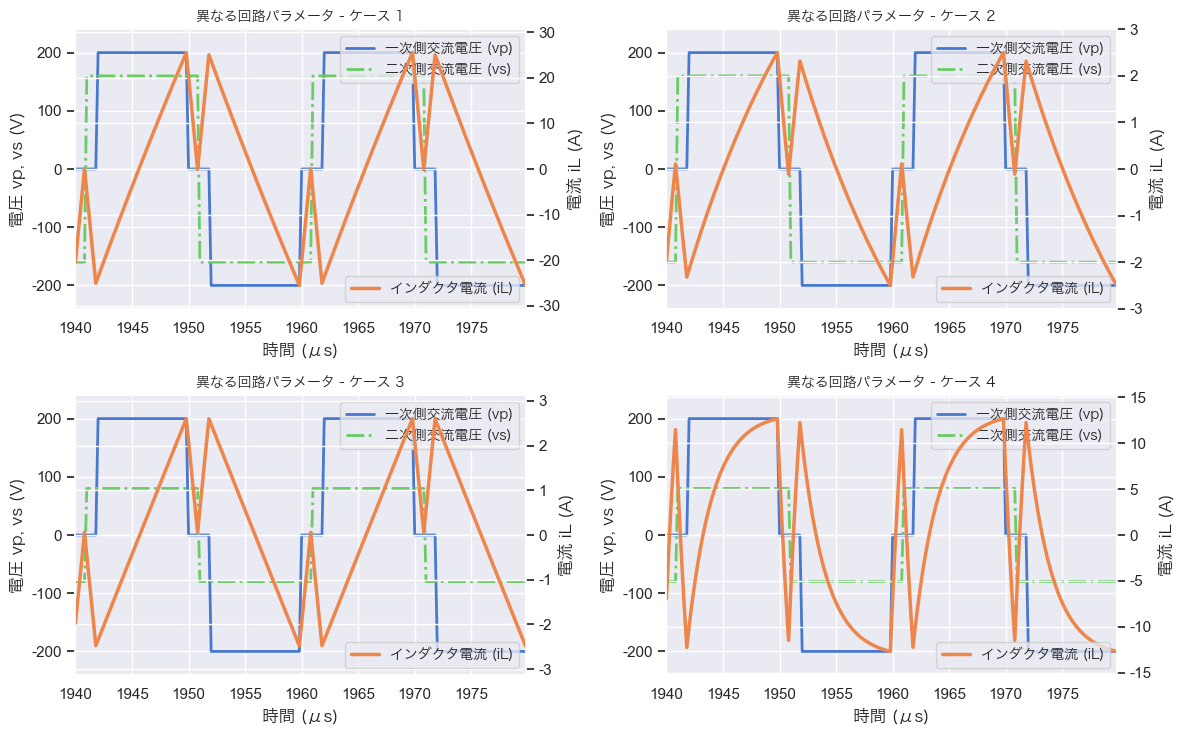

In [11]:
# 最後の2スイッチング周期分のデータを表示用に準備
if len(inputs.shape) == 3:
    t = t[-2 * Tslen :] * 1e6
    inputs = inputs[0, -2 * Tslen :]
    states = states[0, -2 * Tslen :]
    inputs2 = inputs2[0, -2 * Tslen :]
    states2 = states2[0, -2 * Tslen :]
    inputs3 = inputs3[0, -2 * Tslen :]
    states3 = states3[0, -2 * Tslen :]
    inputs4 = inputs4[0, -2 * Tslen :]
    states4 = states4[0, -2 * Tslen :]

# Seabornスタイルの設定
sns.set(style="darkgrid")

t, inputs, states = np.array(t), np.array(inputs), np.array(states)

# 図とサブプロットを作成
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(12, 7.5))

for i, (ax, _inputs, _states) in enumerate(
    zip(
        [ax11, ax12, ax21, ax22],
        [inputs, inputs2, inputs3, inputs4],
        [states, states2, states3, states4],
    )
):
    # 二軸プロット
    ax_2 = ax.twinx()

    # 電圧波形のプロット
    ax.plot(
        t,
        _inputs[:, 0],
        lw=2,
        label="一次側交流電圧 (vp)",
        color=sns.color_palette("muted")[0],
        linestyle="-",
    )
    ax.plot(
        t,
        _inputs[:, 1],
        lw=2,
        label="二次側交流電圧 (vs)",
        color=sns.color_palette("muted")[2],
        linestyle="-.",
    )

    # 電流波形のプロット
    ax_2.plot(
        t,
        _states[:, 0],
        lw=2.5,
        label="インダクタ電流 (iL)",
        color=sns.color_palette("muted")[1],
        linestyle="-",
    )

    # 軸の設定
    ax.set_xlim(t.min(), t.max())
    ax.set_ylim(-_inputs.max() * 1.2, _inputs.max() * 1.2)
    ax_2.set_ylim(-_states.max() * 1.2, _states.max() * 1.2)

    # ラベルとタイトル
    ax.set_title(
        f"異なる回路パラメータ - ケース {i + 1}",
        fontsize=16,
        weight="bold",
        fontproperties=font_prop,
    )
    ax.set_xlabel("時間 (μs)", fontsize=12, fontproperties=font_prop)
    ax.set_ylabel("電圧 vp, vs (V)", fontsize=12, fontproperties=font_prop)
    ax_2.set_ylabel("電流 iL (A)", fontsize=12, fontproperties=font_prop)

    # グリッドと凡例
    ax.grid(True)
    ax.legend(loc="upper right", fontsize=10, prop=font_prop)
    ax_2.legend(loc="lower right", fontsize=10, prop=font_prop)

# レイアウトの調整
plt.tight_layout()
plt.show()

## 4. 多様な性能指標のための一つの PANN モデル（学習不要！一つのモデルで全てに対応！）

### PANN 出力: 時間に対する波形（DAB の場合は iL）

### 多様な性能指標:

- 導通損失／銅損失
- ピークツーピーク／RMS 電流ストレス
- ゼロ電圧スイッチング／ゼロ電流スイッチング
- 伝送電力
- 高調波
- オーバーシュート／整定時間（動的特性を考慮）


In [12]:
# pann_dabの回路パラメータを初期化
pann_dab.cell.n.data = torch.FloatTensor([1.0])
pann_dab.cell.RL.data = torch.FloatTensor([120e-3])
pann_dab.cell.Lr.data = torch.FloatTensor([63e-6])

# 例示的なケースを考慮
D0, D1, D2 = 0.16, 0.7, 0.95
Vin, Vref = 200, 160
Tsim = 100 * Ts  # シミュレーション時間（スイッチング周期の100倍を考慮）

# 変調パラメータのセットから電圧波形（vpとvs）を生成
vp, vs = create_vpvs(
    D0,
    D1,
    D2,
    Vin,
    Vref,
    Tslen,
    dt,
    Tsim,
    Ts,
    D1_cycle=0.5,
    D2_cycle=0.5,
)
t = np.arange(0, len(vp) * dt, dt)
inputs = np.hstack([vp[:, None], vs[:, None]])[None]

# torchのFloatTensorに変換
inputs = torch.FloatTensor(inputs)

# 状態変数を初期化
state_dim = 1
state0 = torch.zeros((inputs.shape[0], 1, state_dim))  # 初期値は0

# PANNを使用して状態変数iLを推論
pann_dab.eval()
with torch.no_grad():
    states = pann_dab(inputs, state0)

/var/folders/f_/5hh5787972x33swmy27z8q0m0000gn/T/ipykernel_54643/27124314.py:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  t, inputs, states = np.array(t), np.array(inputs), np.array(states)


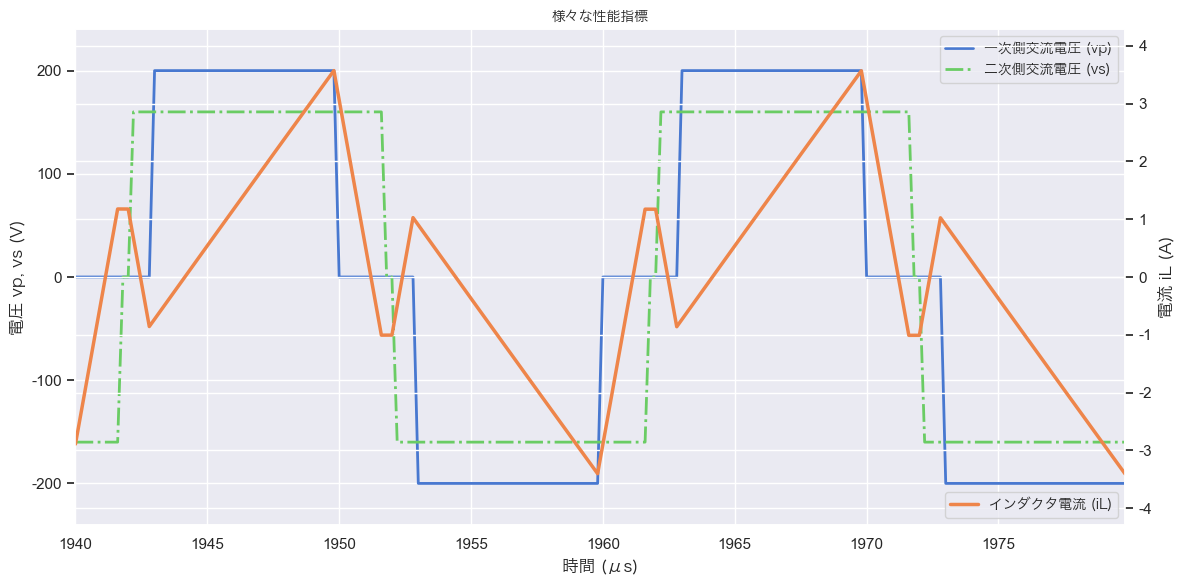

In [13]:
# 最後の2スイッチング周期分のデータを表示用に準備
if len(inputs.shape) == 3:
    t = t[-2 * Tslen :] * 1e6
    inputs = inputs[0, -2 * Tslen :]
    states = states[0, -2 * Tslen :]

# Seabornスタイルの設定
sns.set(style="darkgrid")

t, inputs, states = np.array(t), np.array(inputs), np.array(states)

# 図とサブプロットを作成
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# 二軸プロット
ax_2 = ax.twinx()

# 電圧波形のプロット
ax.plot(
    t,
    inputs[:, 0],
    lw=2,
    label="一次側交流電圧 (vp)",
    color=sns.color_palette("muted")[0],
    linestyle="-",
)
ax.plot(
    t,
    inputs[:, 1],
    lw=2,
    label="二次側交流電圧 (vs)",
    color=sns.color_palette("muted")[2],
    linestyle="-.",
)

# 電流波形のプロット
ax_2.plot(
    t,
    states[:, 0],
    lw=2.5,
    label="インダクタ電流 (iL)",
    color=sns.color_palette("muted")[1],
    linestyle="-",
)

# 軸の設定
ax.set_xlim(t.min(), t.max())
ax.set_ylim(-inputs.max() * 1.2, inputs.max() * 1.2)
ax_2.set_ylim(
    -max(states.max(), abs(states.min())) * 1.2,
    max(states.max(), abs(states.min())) * 1.2,
)

# ラベルとタイトル
ax.set_title(f"様々な性能指標", fontsize=16, weight="bold", fontproperties=font_prop)
ax.set_xlabel("時間 (μs)", fontsize=12, fontproperties=font_prop)
ax.set_ylabel("電圧 vp, vs (V)", fontsize=12, fontproperties=font_prop)
ax_2.set_ylabel("電流 iL (A)", fontsize=12, fontproperties=font_prop)

# グリッドと凡例
ax.grid(True)
ax.legend(loc="upper right", fontsize=10, prop=font_prop)
ax_2.legend(loc="lower right", fontsize=10, prop=font_prop)

# レイアウトの調整
plt.tight_layout()
plt.show()

In [14]:
# 性能指標の計算
# 性能指標 1: ピークツーピーク／RMS電流ストレス
ipp = current_stress(states[:, 0], metric="ipp")
print(f"このケーススタディのピークツーピーク電流は {ipp:.2f} A です。")
print("\n")

# 実効値電流ストレスの取得
irms = current_stress(states[:, 0], metric="irms")
print(f"このケーススタディのRMS電流は {irms:.2f} A です。")
print("\n")

# 性能指標 2: 銅損失
copper_loss = cu_loss(states[:, 0], pann_dab.cell.RL.item())
print(f"このケーススタディの銅損失は: {copper_loss: .3f} W です。")
print("\n")

# 性能指標 3: 伝送電力
active_P = power(inputs[:, 0], inputs[:, 1], states[:, 0], metric="PL")
reactive_Q = power(
    inputs[:, 0], inputs[:, 1], states[:, 0], metric="Q", n=pann_dab.cell.n.item()
)
print(f"有効電力は: {active_P:.3f} W、無効電力は: {reactive_Q:.3f} Var です。")
print("\n")

# 性能指標 4: ゼロ電圧スイッチング／ゼロ電流スイッチング
print("実験データのZVSおよびZCS性能:")
zvs_perform = soft_switching(
    states[:, 0], inputs[:, 0], inputs[:, 1], Vin, Vref, threshold=0.0
)[0]
print(f"ZVSを達成したスイッチの総数は: {sum(zvs_perform)} です。")
print(f"s1からs8のZVSの詳細は: {zvs_perform} です。")

このケーススタディのピークツーピーク電流は 6.97 A です。


このケーススタディのRMS電流は 1.72 A です。


このケーススタディの銅損失は:  0.354 W です。


有効電力は: 187.617 W、無効電力は: 151.481 Var です。


実験データのZVSおよびZCS性能:
ZVSを達成したスイッチの総数は: 8.0 です。
s1からs8のZVSの詳細は: [1. 1. 1. 1. 1. 1. 1. 1.] です。
